#### Calculo de CrossCorrelation Bright/Faint vs UHECRs - TreeCorr

In [26]:

######################
minsep = 10.
maxsep = 90.
nbins = 15
nmult = 50
npatch = 50
nbootstrap = 500

seed1 = 12936
seed2 = 19284

config = {"min_sep": minsep, \
          "max_sep": maxsep, \
            "nbins": nbins, \
            "sep_units": 'degree', \
            "bin_type": 'Linear', \
            "brute": True, \
            "metric": 'Arc', \
            "var_method": 'bootstrap', \
            "num_bootstrap": nbootstrap}

passivecrop = True
write = True
plot = True
######################

import numpy as np
from astropy.io import ascii
from astropy.coordinates import SkyCoord
import astropy.units as u
from auger_tools import generate_RandomCatalogue

# Read UHECR
filename_e = '../data/Auger/events_a8_lb.dat'
events_a8 = ascii.read(filename_e)
# Galaxy Mask
eve = SkyCoord(events_a8['RA'],events_a8['dec'],frame='icrs',unit='degree')
mask_eve = np.where([abs(eve.galactic.b)>5.*(u.degree)])[1]
events_a8 = events_a8[mask_eve]

# Read Gxs
if passivecrop==True: filename_g = '../data/VLS/2MRSxWISE_VLS_passivecrop.txt'
else: filename_g = '../data/VLS/2MRSxWISE_VLS.txt'
data = ascii.read(filename_g)

# Bright/Faint
data_bright = data[(data['K_abs']<-23.2)&(data['K_abs']>-26.)]
data_faint = data[(data['K_abs']>-23.2)&(data['K_abs']<-22.)]

# Random Catalogue
rand_ra1, rand_dec1 = generate_RandomCatalogue(data_bright['_RAJ2000'],data_bright['_DEJ2000'],\
                                               nmult,seed1, mask=True)
rand_ra2, rand_dec2 = generate_RandomCatalogue(data_faint['_RAJ2000'],data_faint['_DEJ2000'],\
                                               nmult,seed2, mask=True)

"""
BRIGHT
"""
# TreeCorr Catalogues
import treecorr

gcat = treecorr.Catalog(ra=data_bright['_RAJ2000'], dec=data_bright['_DEJ2000'],\
                        ra_units='deg', dec_units='deg', npatch=npatch)
ecat = treecorr.Catalog(ra=events_a8['RA'], dec=events_a8['dec'], \
                        ra_units='deg', dec_units='deg', patch_centers=gcat.patch_centers)
rcat1 = treecorr.Catalog(ra=rand_ra1, dec=rand_dec1, \
                        ra_units='deg', dec_units='deg', npatch=npatch)
rcat2 = treecorr.Catalog(ra=rand_ra2, dec=rand_dec2, \
                        ra_units='deg', dec_units='deg', npatch=npatch)


dd = treecorr.NNCorrelation(config)
dr = treecorr.NNCorrelation(config)
rr = treecorr.NNCorrelation(config)
rd = treecorr.NNCorrelation(config)

rr.process(rcat1)
dd.process(gcat,ecat)
dr.process(gcat,rcat1)
rd.process(ecat,rcat1)

xi1, varxi1 = dd.calculateXi(rr=rr,dr=dr,rd=rd)


"""
FAINT
"""
gcat = treecorr.Catalog(ra=data_faint['_RAJ2000'], dec=data_faint['_DEJ2000'],\
                        ra_units='deg', dec_units='deg', npatch=npatch)

rr.process(rcat2)
dd.process(gcat,ecat)
dr.process(gcat,rcat2)
rd.process(ecat,rcat2)

xi2, varxi2 = dd.calculateXi(rr=rr,dr=dr,rd=rd)

#### Plot

[0.04918742 0.04306679 0.03780582 0.03236703 0.02622928 0.02237979
 0.02044908 0.017934   0.01552237 0.01461993 0.01485959 0.01490341
 0.0148129  0.01290886 0.01091517]
[0.22178237 0.2075254  0.19443719 0.17990841 0.16195455 0.14959877
 0.14300028 0.13391788 0.12458879 0.12091291 0.12189991 0.12207951
 0.12170827 0.11361717 0.10447569]


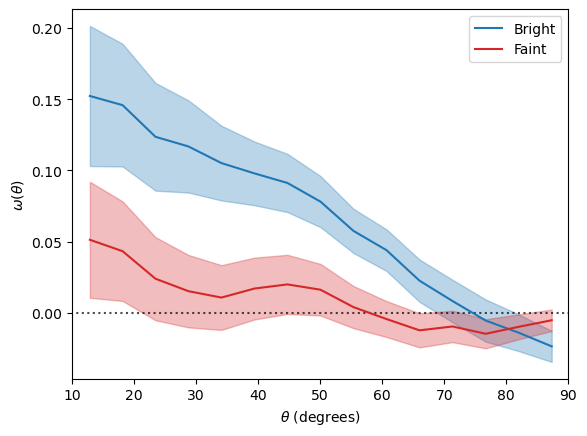

In [27]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

fig, ax = plt.subplots()

sig1 = (varxi1)
sig2 = (varxi2)
print(sig1)
print(np.sqrt(varxi1))

r = dd.meanr

ax.hlines(0.,0.,90.,ls=':',color='k',alpha=.7)

ax.plot(r, xi1, color='C0', label='Bright')
ax.plot(r, xi2, color='C3', label='Faint')

ax.fill_between(r, y1=xi1-sig1, y2=xi1+sig1, \
                color='C0', alpha=.3)
ax.fill_between(r, y1=xi2-sig2, y2=xi2+sig2, \
                color='C3', alpha=.3)


ax.legend()

ax.set_xlabel(r'$\theta$ (degrees)')
ax.set_ylabel(r'$\omega(\theta)$')

ax.set_xlim([minsep,maxsep])

ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

if plot==True:
    plotname = f'../data/cross_treecorr_bf_{nmult}'
    if passivecrop==True: plotname+='_passivecrop'
    plt.savefig(plotname+'.png')

plt.show()


#### Write

In [28]:
if write==True:
    fname_b = f'../data/treecorr_cross_bright_{nmult}'
    fname_f = f'../data/treecorr_cross_faint_{nmult}'
    if passivecrop==True:
        fname_b+='_passivecrop'
        fname_f+='_passivecrop'

    np.savez(fname_b+'_discard.npz',r,xi1,sig1)
    np.savez(fname_f+'_discard.npz',r,xi2,sig2)